# 1. Dimensionality Reduction

In [55]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
import re
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from pathlib import Path
import plotly.graph_objects as go
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)

In [56]:
save_dir = "/Users/jen-hung/Desktop/KTH/mnp-liver/results/"

## Load data

In [ ]:
# Load data
csv_dir = Path("/Users/jen-hung/Desktop/KTH/mnp-liver/csv_data")
hep_path = csv_dir / "hep"
csv_data = "df_SingleCell_AO_HEPG2_102912.csv" # "df_SingleCell_AO_HEPG2_102912.csv", "df_SingleCell_AO_HEPG2_110341.csv", "df_SingleCell_AO_HEPG2_231222.csv"
f = hep_path / csv_data

# f1 = hep_path / "df_SingleCell_AO_HEPG2_102912.csv"
# f2 = hep_path / "df_SingleCell_AO_HEPG2_110341.csv"
# f3 = hep_path / "df_SingleCell_AO_HEPG2_2±%X

# df1 = pd.read_csv(f1, sep=",", header=0)
df = pd.read_csv(f, sep=",", header=0)
# df3 = pd.read_csv(f3, sep=",", header=0)

/var/folders/kf/6q75_scn7650xfyhtyvv65140000gn/T/ipykernel_3301/1069245890.py:12: DtypeWarning:

Columns (1637) have mixed types. Specify dtype option on import or set low_memory=False.



### (Optional) Print first values of selected columns

In [ ]:
# Define columns of interest
columns_of_interest = [
    'Cells_AreaShape_NormalizedMoment_0_0',
    'Cells_AreaShape_NormalizedMoment_0_1',
    'Cells_AreaShape_NormalizedMoment_1_0',
    'Nuclei_AreaShape_NormalizedMoment_0_0',
    'Nuclei_AreaShape_NormalizedMoment_0_1',
    'Nuclei_AreaShape_NormalizedMoment_1_0'
]

# Print first 10 values for specified columns
print("\nFirst 10 values for specified columns:")
for col in columns_of_interest:
    if col in df.columns:
        print(f"\n{col}:")
        print(df[col].head(10).to_list())
    else:
        print(f"\n{col}: Not found in DataFrame")

In [ ]:
df.head()

In [ ]:
objectnumber_columns = [col for col in df.columns if '_ObjectNumber' in col]
print(objectnumber_columns)

## Randomly drop NC for data balancing

In [82]:
column_name = 'Metadata_concentration_perliter' 
# column_name = 'Metadata_compound' 
# column_name = 'Metadata_control_type'

# Standardize '0' values (convert numeric 0 or similar to string '0')
# df[column_name] = df[column_name].apply(lambda x: '0' if pd.to_numeric(x, errors='coerce') == 0 else x)

value_counts = df[column_name].value_counts()
print(f"Unique values and their counts in column '{column_name}':")
print(value_counts)

Unique values and their counts in column 'Metadata_concentration_perliter':
Metadata_concentration_perliter
0        11264
1mg       4922
0.1g      4875
0.01g     4759
1ng       4654
0.5g      4649
1ug       4463
1g        4263
0         1747
Name: count, dtype: int64


In [86]:
import pandas as pd
import numpy as np

# Assuming df is your DataFrame and column_name is defined
column_name = 'Metadata_concentration_perliter'

# Define the fraction to keep (%)
percentage_to_keep = 38

# Standardize '0' values (convert numeric 0 or similar to string '0')
df[column_name] = df[column_name].apply(lambda x: '0' if pd.to_numeric(x, errors='coerce') == 0 else x)

# Identify rows where Metadata_concentration_perliter == '0'
zero_rows = df[df[column_name] == '0']

# Calculate number of rows to keep
rows_to_keep = int(len(zero_rows) * percentage_to_keep / 100)
print(f"Number of rows with {column_name} == '0': {len(zero_rows)}")
print(f"Number of rows to keep ({percentage_to_keep:.2f}% of zeros): {rows_to_keep}")

# Randomly sample the zero rows to keep
zero_rows_to_keep = zero_rows.sample(n=rows_to_keep, random_state=42)

# Get rows where Metadata_concentration_perliter != '0'
non_zero_rows = df[df[column_name] != '0']

# Combine the kept zero rows with non-zero rows
df_filtered = pd.concat([zero_rows_to_keep, non_zero_rows])

# Reset index if needed
df_filtered = df_filtered.reset_index(drop=True)

# Verify the new counts
value_counts = df_filtered[column_name].value_counts()
print(f"Unique values and their counts in column '{column_name}' after dropping {100 - percentage_to_keep:.2f}% of zeros:")
print(value_counts)

Number of rows with Metadata_concentration_perliter == '0': 13011
Number of rows to keep (38.00% of zeros): 4944
Unique values and their counts in column 'Metadata_concentration_perliter' after dropping 62.00% of zeros:
Metadata_concentration_perliter
0        4944
1mg      4922
0.1g     4875
0.01g    4759
1ng      4654
0.5g     4649
1ug      4463
1g       4263
Name: count, dtype: int64


## Data preprocessing

In [87]:
def preprocess_dataframe(df, nan_threshold=0.05):
    # Select feature columns
    feature_columns = [col for col in df.columns if not col.startswith(('Metadata_', 'Image_')) and not col.endswith('_ObjectNumber')]
    # print("Selected feature columns:", feature_columns)
    print("Number of feature columns:", len(feature_columns))
    
    # Extract features
    X = df[feature_columns]
    
    # Calculate NaN and Inf counts
    nan_counts = X.isna().sum()
    inf_counts = np.isinf(X).sum()
    
    # Identify columns with at least one NaN or Inf
    columns_with_nan_or_inf = nan_counts[nan_counts > 0].index.union(inf_counts[inf_counts > 0].index)
    
    if len(columns_with_nan_or_inf) > 0:
        print("\nColumns with at least one NaN or Inf value:")
        print("\n{:<60} {:>10} {:>10}".format("Column", "NaN Count", "Inf Count"))
        print("-" * 80)
        for col in columns_with_nan_or_inf:
            print("{:<60} {:>10} {:>10}".format(col, nan_counts[col], inf_counts[col]))
        print(f"Total columns with NaN or Inf: {len(columns_with_nan_or_inf)}")
    
    # Filter columns based on NaN and Inf threshold
    threshold = X.shape[0] * nan_threshold
    valid_columns = [col for col in X.columns if X[col].isna().sum() < threshold and np.isinf(X[col]).sum() < threshold]
    # print("\nValid columns after filtering (>50% valid data):", valid_columns)
    print("Number of valid columns:", len(valid_columns))
    
    if not valid_columns:
        raise ValueError("No valid columns remain after filtering.")
    
    # Select valid columns
    X = X[valid_columns]
    
    # Replace inf with NaN
    X = X.replace([np.inf, -np.inf], np.nan)
    
    # Fill NaN with median
    X = X.fillna(X.median())
    
    # Check for remaining NaN values
    nan_count_after_fill = X.isna().sum().sum()
    print("\nNaN count after filling with median:", nan_count_after_fill)
    if nan_count_after_fill > 0:
        print("Warning: Some NaN values remain. Filling with zero.")
        X = X.fillna(0)
    
    # Check if data is valid
    if X.shape[0] == 0 or X.shape[1] == 0:
        raise ValueError("No rows/columns remain after preprocessing.")
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, valid_columns

In [ ]:
# Preprocess each DataFrame
# dataframes = {'df1': df1, 'df2': df2, 'df3': df3}
# dataframes = {'df': df}
dataframes = {'df': df_filtered}
preprocessed_data = {}

# print(f"Original df1 shape: {df1.shape}")
# print(f"Original df2 shape: {df2.shape}")
# print(f"Original df3 shape: {df3.shape}")

for name, df in dataframes.items():
    print(f"Original {name} shape: {df.shape}")
    print(f"Preprocessing {name}...")
    X_scaled, valid_columns = preprocess_dataframe(df)
    preprocessed_data[name] = {'X_scaled': X_scaled, 'valid_columns': valid_columns, 'df': df}
    print(f"Preprocessed {name} with {len(valid_columns)} valid columns.\n")

Original df shape: (37529, 1639)
Preprocessing df...
Number of feature columns: 1627

Columns with at least one NaN or Inf value:

Column                                                        NaN Count  Inf Count
--------------------------------------------------------------------------------
Cells_AreaShape_NormalizedMoment_0_0                              37529          0
Cells_AreaShape_NormalizedMoment_0_1                              37529          0
Cells_AreaShape_NormalizedMoment_1_0                              37529          0
Nuclei_AreaShape_NormalizedMoment_0_0                             37529          0
Nuclei_AreaShape_NormalizedMoment_0_1                             37529          0
Nuclei_AreaShape_NormalizedMoment_1_0                             37529          0
Nuclei_Mean_Nucleoli_AreaShape_Area                               16684          0
Nuclei_Mean_Nucleoli_AreaShape_BoundingBoxArea                    16684          0
Nuclei_Mean_Nucleoli_AreaShape_BoundingBo

## 2D & 3D Plot

In [89]:
def plot_dimensionality_reduction(X_scaled, df, valid_columns, metadata_column, method_name, title, tsne_perplexity=30, n_neighbors=15, min_dist=0.1, continuous=True, n_components=2, save_path=None):
    if method_name == 'PCA':
        reducer = PCA(n_components=n_components)
        x_label = 'PC1'
        y_label = 'PC2'
        z_label = 'PC3' if n_components == 3 else None
    elif method_name == 't-SNE':
        reducer = TSNE(n_components=n_components, perplexity=tsne_perplexity, learning_rate='auto', random_state=42)
        x_label = 't-SNE 1'
        y_label = 't-SNE 2'
        z_label = 't-SNE 3' if n_components == 3 else None
    elif method_name == 'UMAP':
        reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
        x_label = 'UMAP 1'
        y_label = 'UMAP 2'
        z_label = 'UMAP 3' if n_components == 3 else None
    elif method_name == 'LDA':
        labels = df[metadata_column].astype(str)
        reducer = LDA(n_components=n_components)
        X_reduced = reducer.fit_transform(X_scaled, labels)
        x_label = 'LD1'
        y_label = 'LD2'
        z_label = 'LD3' if n_components == 3 else None
    else:
        raise ValueError("Unsupported method")
    
    if method_name != 'LDA':
        X_reduced = reducer.fit_transform(X_scaled)
    
    # 2D Plot
    if n_components == 2:
        fig_2d = go.Figure()
        if continuous:
            concentrations = df[metadata_column].apply(convert_concentration)
            fig_2d.add_trace(go.Scatter(x=X_reduced[:, 0], y=X_reduced[:, 1], mode='markers',
                                        marker=dict(color=concentrations, colorscale='Viridis', showscale=True, colorbar=dict(title=f'{metadata_column} (g)'))))
            title += ' (Continuous)'
        else:
            labels = df[metadata_column].astype(str)
            unique_labels = sorted(labels.unique(), key=convert_concentration, reverse=True)
            color_map = {label: f'rgb({r}, {g}, {b})' for label, (r, g, b) in zip(unique_labels, sns.color_palette('tab10', len(unique_labels)))}
            for label in unique_labels:
                mask = labels == label
                fig_2d.add_trace(go.Scatter(
                    x=X_reduced[mask, 0], 
                    y=X_reduced[mask, 1], 
                    mode='markers',
                    marker=dict(color=color_map[label], size=3),
                    name=str(label),
                    showlegend=True
                ))
            fig_2d.update_layout(showlegend=True, legend=dict(itemsizing='constant'))
            title += ' (Categorical)'
        fig_2d.update_layout(title=title + f' (2D, {len(valid_columns)} features)', xaxis_title=x_label, yaxis_title=y_label)
        fig_2d.show()
        # Save 2D plot as PNG if save_path is provided
        if save_path:
            fig_2d.write_image(f"{save_path}_2D.png", width=1200, height=800)
    
    # 3D Plot (if n_components = 3)
    if n_components == 3:
        fig_3d = go.Figure()
        if continuous:
            concentrations = df[metadata_column].apply(convert_concentration)
            fig_3d.add_trace(go.Scatter3d(x=X_reduced[:, 0], y=X_reduced[:, 1], z=X_reduced[:, 2], mode='markers',
                                          marker=dict(color=concentrations, colorscale='Viridis', showscale=True, colorbar=dict(title=f'{metadata_column} (g)'))))
            title += ' (Continuous)'
        else:
            labels = df[metadata_column].astype(str)
            unique_labels = sorted(labels.unique(), key=convert_concentration, reverse=True)
            color_map = {label: f'rgb({r}, {g}, {b})' for label, (r, g, b) in zip(unique_labels, sns.color_palette('tab10', len(unique_labels)))}
            for label in unique_labels:
                mask = labels == label
                fig_3d.add_trace(go.Scatter3d(
                    x=X_reduced[mask, 0], 
                    y=X_reduced[mask, 1], 
                    z=X_reduced[mask, 2], 
                    mode='markers',
                    marker=dict(color=color_map[label], size=3),
                    name=str(label),
                    showlegend=True
                ))
            fig_3d.update_layout(showlegend=True, legend=dict(itemsizing='constant'))
            title += ' (Categorical)'
        fig_3d.update_layout(title=title + f' (3D, {len(valid_columns)} features)', 
                             scene=dict(xaxis_title=x_label, yaxis_title=y_label, zaxis_title=z_label))
        fig_3d.show()
        # Save 3D plot as PNG if save_path is provided
        if save_path:
            fig_3d.write_image(f"{save_path}_3D.png", width=1200, height=800)
            
    return fig_2d if n_components == 2 else fig_3d
    
    # Function to convert concentration strings to numerical values (grams)
def convert_concentration(value):
    if pd.isna(value) or value == "":
        return 0.0
    try:
        value = str(value).lower().replace(" ", "")  # Normalize input
        # Use regex to extract number and unit
        match = re.match(r'(\d*\.?\d+)([mnu]?g)?', value)
        if match:
            num = float(match.group(1))
            unit = match.group(2) or ''
            if unit == 'mg':
                return num * 1e-3  # Convert mg to g
            elif unit == 'ug':
                return num * 1e-6  # Convert ug to g
            elif unit == 'ng':
                return num * 1e-9  # Convert ng to g
            elif unit == 'g' or not unit:  # Includes pure numbers or 'g'
                return num
        return float(value)  # Fallback for pure numbers
    except ValueError:
        return 0.0  # Default to 0 for invalid entries
    


## PCA

In [ ]:
# Apply dimensionality reduction methods to each DataFrame
metadata_column = 'Metadata_concentration_perliter'
method = 'PCA'

for name, data in preprocessed_data.items():
    if metadata_column in data['df'].columns:
        # 2D plots
        # plot_dimensionality_reduction(data['X_scaled'], data['df'], data['valid_columns'], metadata_column,
        #                                 method, f"{method} of {csv_data}", continuous=True, n_components=2)
        plot_dimensionality_reduction(data['X_scaled'], data['df'], data['valid_columns'], metadata_column,
                                      method, f"{method} of {csv_data}", continuous=False, n_components=2)
        
        # 3D plots
        # plot_dimensionality_reduction(data['X_scaled'], data['df'], data['valid_columns'], metadata_column,
        #                                 method, f"{method} of {csv_data}", continuous=True, n_components=3)
        plot_dimensionality_reduction(data['X_scaled'], data['df'], data['valid_columns'], metadata_column,
                                      method, f"{method} of {csv_data}", continuous=False, n_components=3)
    else:
        print(f"Warning: {metadata_column} not found in {name}.")

## t-SNE

In [ ]:
# Apply dimensionality reduction methods to each DataFrame
metadata_column = 'Metadata_concentration_perliter'
method = 't-SNE'
# save_dir = '/Users/jen-hung/Desktop/KTH/mnp-liver/results/'

for name, data in preprocessed_data.items():
    if metadata_column in data['df'].columns:
        # 2D plots
        # plot_dimensionality_reduction(data['X_scaled'], data['df'], data['valid_columns'], metadata_column,
        #                                 method, f"{method} of {csv_data}", continuous=True, n_components=2)
        plot_dimensionality_reduction(data['X_scaled'], data['df'], data['valid_columns'], metadata_column,
                                      method, f"{method} of {csv_data}", continuous=False, n_components=2, 
                                      save_path=save_dir + f"{csv_data}_{method}")
        
        # 3D plots
        # plot_dimensionality_reduction(data['X_scaled'], data['df'], data['valid_columns'], metadata_column,
        #                                 method, f"{method} of {csv_data}", continuous=True, n_components=3)
        plot_dimensionality_reduction(data['X_scaled'], data['df'], data['valid_columns'], metadata_column,
                                      method, f"{method} of {csv_data}", continuous=False, n_components=3, 
                                      save_path=save_dir + f"{csv_data}_{method}")
    else:
        print(f"Warning: {metadata_column} not found in {name}.")

## UMAP

In [ ]:
# Apply dimensionality reduction methods to each DataFrame
metadata_column = 'Metadata_concentration_perliter'
method = 'UMAP'
# save_dir = '/Users/jen-hung/Desktop/KTH/mnp-liver/results/'

for name, data in preprocessed_data.items():
    if metadata_column in data['df'].columns:
        # 2D plots
        # plot_dimensionality_reduction(data['X_scaled'], data['df'], data['valid_columns'], metadata_column,
        #                                 method, f"{method} of {csv_data}", continuous=True, n_components=2)
        plot_dimensionality_reduction(data['X_scaled'], data['df'], data['valid_columns'], metadata_column,
                                      method, f"{method} of {csv_data}", continuous=False, n_components=2, 
                                      save_path=save_dir + f"{csv_data}_{method}")
        
        # 3D plots
        # plot_dimensionality_reduction(data['X_scaled'], data['df'], data['valid_columns'], metadata_column,
        #                                 method, f"{method} of {csv_data}", continuous=True, n_components=3)
        plot_dimensionality_reduction(data['X_scaled'], data['df'], data['valid_columns'], metadata_column,
                                      method, f"{method} of {csv_data}", continuous=False, n_components=3, 
                                      save_path=save_dir + f"{csv_data}_{method}")
    else:
        print(f"Warning: {metadata_column} not found in {name}.")

## LDA

In [90]:
# Apply dimensionality reduction methods to each DataFrame
metadata_column = 'Metadata_concentration_perliter'
method = 'LDA'
# save_dir = "/home/jen-hungwang/Desktop/"

for name, data in preprocessed_data.items():
    if metadata_column in data['df'].columns:
        # 2D plots
        # plot_dimensionality_reduction(data['X_scaled'], data['df'], data['valid_columns'], metadata_column,
        #                                 method, f"{method} of {csv_data}", continuous=True, n_components=2)
        plot_dimensionality_reduction(data['X_scaled'], data['df'], data['valid_columns'], metadata_column,
                                      method, f"{method} of {csv_data}", continuous=False, n_components=2, 
                                      save_path=save_dir + f"{csv_data}_{method}")
        
        # 3D plots
        # plot_dimensionality_reduction(data['X_scaled'], data['df'], data['valid_columns'], metadata_column,
        #                                 method, f"{method} of {csv_data}", continuous=True, n_components=3)
        fig_original = plot_dimensionality_reduction(data['X_scaled'], data['df'], data['valid_columns'], metadata_column,
                                      method, f"{method} of {csv_data}", continuous=False, n_components=3,
                                      save_path=save_dir + f"{csv_data}_{method}")
    else:
        print(f"Warning: {metadata_column} not found in {name}.")

# 2. Fine-tune dimensionality reduction methods

## t-SNE

In [ ]:
# Apply dimensionality reduction methods to each DataFrame
metadata_column = 'Metadata_concentration_perliter'
method = 't-SNE'
perplexity = [2, 5, 10, 20, 30, 50, 100]
save_dir = "/home/jen-hungwang/Desktop/t-sne/"

for name, data in preprocessed_data.items():
    for p in perplexity:
        if metadata_column in data['df'].columns:
            print(f"Hyperparameters: perplexity={p}")
            # 2D plots
            # plot_dimensionality_reduction(data['X_scaled'], data['df'], data['valid_columns'], metadata_column,
            #                                 method, f"{method} of {name}", continuous=True, n_components=2)
            plot_dimensionality_reduction(data['X_scaled'], data['df'], data['valid_columns'], metadata_column,
                                          method, f"{method} of {name}, perplexity={p}", tsne_perplexity=p, continuous=False, n_components=2, save_path=save_dir + f"{name}_{method}_p{p}")
            
            # 3D plots
            # plot_dimensionality_reduction(data['X_scaled'], data['df'], data['valid_columns'], metadata_column,
            #                                 method, f"{method} of {name}", continuous=True, n_components=3)
            # plot_dimensionality_reduction(data['X_scaled'], data['df'], data['valid_columns'], metadata_column,
            #                               method, f"{method} of {name}, perplexity={p}", tsne_perplexity=p, continuous=False, n_components=3, save_path=save_dir + f"{name}_{method}_p{p}")
        else:
            print(f"Warning: {metadata_column} not found in {name}.")

## UMAP

In [ ]:
# Apply dimensionality reduction methods to each DataFrame
metadata_column = 'Metadata_concentration_perliter'
method = 'UMAP'
# n_neighbors = [2, 5, 10, 20, 50, 100, 200]
n_neighbors = [200]
min_dist = [0.1, 0.25, 0.5, 0.8, 0.99]
save_dir = "/home/jen-hungwang/Desktop/umap/n200/"

for name, data in preprocessed_data.items():
    for n in n_neighbors:
        for m in min_dist:
            if metadata_column in data['df'].columns:
                print(f"Hyperparameters: n_neighbors={n}, min_dist={m}")
                # 2D plots
                # plot_dimensionality_reduction(data['X_scaled'], data['df'], data['valid_columns'], metadata_column,
                #                                 method, f"{method} of {name}", continuous=True, n_components=2)
                plot_dimensionality_reduction(data['X_scaled'], data['df'], data['valid_columns'], metadata_column,
                                              method, f"{method} of {name}, n_neighbors={n}, min_dist={m}", n_neighbors=n, min_dist=m, continuous=False, n_components=2, save_path=save_dir + f"{name}_{method}_n{n}_m{m}")
                
                # 3D plots
                # plot_dimensionality_reduction(data['X_scaled'], data['df'], data['valid_columns'], metadata_column,
                #                                 method, f"{method} of {name}", continuous=True, n_components=3)
                # plot_dimensionality_reduction(data['X_scaled'], data['df'], data['valid_columns'], metadata_column,
                #                               method, f"{method} of {name}, n_neighbors={n}, min_dist={m}", n_neighbors=n, min_dist=m, continuous=False, n_components=3, save_path=save_dir + f"{name}_{method}_n{n}_m{m}")
            else:
                print(f"Warning: {metadata_column} not found in {name}.")

# 3. Clustering

In [64]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from plotly.subplots import make_subplots

In [65]:
def perform_clustering(X_reduced, df, metadata_column, method_name, reduction_method, n_clusters=3, eps=0.5, min_samples=5, covariance='full', save_path=None):
    if method_name == 'KMeans':
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    elif method_name == 'DBSCAN':
        clusterer = DBSCAN(eps=eps, min_samples=min_samples)
    elif method_name == 'Agglomerative':
        clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    elif method_name == 'GaussianMixture':
        clusterer = GaussianMixture(n_components=n_clusters, random_state=42, covariance_type=covariance)
    else:
        raise ValueError("Unsupported clustering method")
    
    if df is None:
        df = X_reduced

    # Fit the clustering model
    labels = clusterer.fit_predict(df)
    
    # Compute evaluation metrics
    metrics = {}
    if len(np.unique(labels)) > 1:  # Metrics require at least 2 clusters
        metrics['Silhouette'] = silhouette_score(X_reduced, labels) if len(np.unique(labels)) < X_reduced.shape[0] else -1
        if method_name == 'GaussianMixture':
            metrics['BIC'] = clusterer.bic(X_reduced)
        else:
            metrics['BIC'] = np.nan
    else:
        metrics['Silhouette'] = np.nan
        metrics['BIC'] = np.nan
    # Initialize figure
    fig = go.Figure()
    unique_labels = np.unique(labels)
    color_map = {label: f'rgb({r*255:.0f}, {g*255:.0f}, {b*255:.0f})' for label, (r, g, b) in zip(unique_labels, sns.color_palette('tab10', len(unique_labels)))}
    
    # Create metrics text for display
    metrics_text = (f"Silhouette: {metrics['Silhouette']:.3f}<br>"
                    f"BIC: {metrics['BIC']:.3f}")
    
    # Check dimensionality of X_reduced for 2D or 3D visualization
    if X_reduced.shape[1] >= 3:
        # 3D Visualization
        for label in unique_labels:
            mask = labels == label
            fig.add_trace(go.Scatter3d(
                x=X_reduced[mask, 0], 
                y=X_reduced[mask, 1], 
                z=X_reduced[mask, 2],
                mode='markers',
                marker=dict(size=3, color=color_map[label], opacity=0.8),
                name=f'Cluster {label}' if label != -1 else 'Noise',
                showlegend=True
            ))
        
        # Set axis labels based on reduction method for 3D
        if reduction_method == 'PCA':
            x_label, y_label, z_label = 'PC1', 'PC2', 'PC3'
        elif reduction_method == 'LDA':
            x_label, y_label, z_label = 'LD1', 'LD2', 'LD3'
        elif reduction_method == 't-SNE':
            x_label, y_label, z_label = 't-SNE 1', 't-SNE 2', 't-SNE 3'
        elif reduction_method == 'UMAP':
            x_label, y_label, z_label = 'UMAP 1', 'UMAP 2', 'UMAP 3'
        else:
            x_label, y_label, z_label = 'Component 1', 'Component 2', 'Component 3'
        
        fig.update_layout(
            title=f'{method_name} Clustering on {reduction_method} (3D, {len(unique_labels)} clusters)',
            scene=dict(
                xaxis_title=x_label,
                yaxis_title=y_label,
                zaxis_title=z_label
            ),
            showlegend=True,
            legend=dict(x=0.5, y=0, xanchor="center", yanchor="bottom", orientation="h"),
            annotations=[
                dict(
                    x=0.95,
                    y=0.95,
                    xref="paper",
                    yref="paper",
                    text=metrics_text,
                    showarrow=False,
                    align="right",
                    font=dict(size=12),
                    bgcolor="rgba(255, 255, 255, 0.8)",
                    bordercolor="black",
                    borderwidth=1
                )
            ]
        )
        # plot_filename = f'{method_name}_{reduction_method}_3D_clustering.png' if save_path is None else f'{save_path}.png'
    
    else:
        # 2D Visualization
        for label in unique_labels:
            mask = labels == label
            fig.add_trace(go.Scatter(
                x=X_reduced[mask, 0], 
                y=X_reduced[mask, 1], 
                mode='markers',
                marker=dict(color=color_map[label], size=3),
                name=f'Cluster {label}' if label != -1 else 'Noise',
                showlegend=True
            ))
        
        # Set axis labels based on reduction method for 2D
        if reduction_method == 'PCA':
            x_label, y_label = 'PC1', 'PC2'
        elif reduction_method == 'LDA':
            x_label, y_label = 'LD1', 'LD2'
        elif reduction_method == 't-SNE':
            x_label, y_label = 't-SNE 1', 't-SNE 2'
        elif reduction_method == 'UMAP':
            x_label, y_label = 'UMAP 1', 'UMAP 2'
        else:
            x_label, y_label = 'Component 1', 'Component 2'
        
        fig.update_layout(
            title=f'{method_name} Clustering of {csv_data} on {reduction_method} (2D, {len(unique_labels)} clusters)',
            xaxis_title=x_label,
            yaxis_title=y_label,
            showlegend=True,
            legend=dict(x=0.5, y=0, xanchor="center", yanchor="bottom", orientation="h"),
            annotations=[
                dict(
                    x=0.95,
                    y=0.95,
                    xref="paper",
                    yref="paper",
                    text=metrics_text,
                    showarrow=False,
                    align="right",
                    font=dict(size=12),
                    bgcolor="rgba(255, 255, 255, 0.8)",
                    bordercolor="black",
                    borderwidth=1
                )
            ]
        )
        # plot_filename = f'{method_name}_{reduction_method}_2D_clustering.png' if save_path is None else f'{save_path}.png'
    
    # Save the plot as PNG if save_png is True
    if save_path:
        fig.write_image(f"{save_path}.png", width=1200, height=800)
    
    fig.show()
    
    return labels, fig

In [66]:
def visualize_cluster_concentration_distribution(df, metadata_column, labels, cluster_method, reduction_method, dim, save_path=None):
    # Extract unique clusters (excluding noise if present, e.g., -1 in DBSCAN)
    unique_clusters = np.unique(labels[labels != -1])
    n_clusters = len(unique_clusters)
    
    # Determine grid layout (e.g., 2 columns, rows adjust based on number of clusters)
    cols = min(2, n_clusters)  # Maximum 2 columns for readability
    rows = (n_clusters + cols - 1) // cols  # Calculate rows needed
    
    # Create subplot figure
    fig = make_subplots(rows=rows, cols=cols, subplot_titles=[f'Cluster {cluster}' for cluster in unique_clusters])
    
    # Get unique concentration values and convert to numerical for sorting
    concentration_values = df[metadata_column].unique()
    # print("Raw concentration values:", concentration_values)
    converted_values = np.array([convert_concentration(val) for val in concentration_values])
    # print("Converted values:", converted_values)
    # Sort indices based on converted values in descending order
    sort_indices = np.argsort(converted_values)[::-1]
    sorted_concentration_values = concentration_values[sort_indices]
    # print("Sorted concentration values:", sorted_concentration_values)
    
    
    # Add bar charts for each cluster
    for idx, cluster in enumerate(unique_clusters):
        row = (idx // cols) + 1
        col = (idx % cols) + 1
        
        cluster_mask = labels == cluster
        cluster_concentrations = df[metadata_column][cluster_mask]
        counts = np.zeros(len(sorted_concentration_values), dtype=int)
        for i, conc in enumerate(sorted_concentration_values):
            counts[i] = np.sum(cluster_concentrations == conc)
        
        fig.add_trace(
            go.Bar(
                x=sorted_concentration_values,
                y=counts,
                marker_color='rgb(31, 78, 121)'
            ),
            row=row,
            col=col
        )
    
    # Update layout with enhanced resolution and detailed title
    fig.update_layout(
        title_text=f'Concentration Distribution of {csv_data} Across Clusters ({reduction_method}, {cluster_method}, {n_clusters} Clusters, {dim}D)',
        height=400 * rows,  # Increased for better resolution
        width=800 * cols,   # Increased for better resolution
        showlegend=False    # No global legend since each subplot is labeled
    )
    
    # Update axes titles for all subplots
    for i in range(rows):
        for j in range(cols):
            fig.update_xaxes(title_text='Concentration Levels', row=i+1, col=j+1)
            fig.update_yaxes(title_text='Count', row=i+1, col=j+1)
    
    # Save the plot as PNG if save_path is provided
    if save_path is not None:
        fig.write_image(f"{save_path}/{name}_{reduction_method}_{cluster_method}_{dim}D_{n_clusters}clusters_histogram.png", width=800 * cols, height=400 * rows)
    
    fig.show()

In [ ]:
# Apply clustering to reduced data from PCA, LDA, t-SNE, and UMAP
metadata_column = 'Metadata_concentration_perliter'
# clustering_methods = ['KMeans', 'DBSCAN', 'Agglomerative', 'GaussianMixture']
clustering_methods = ['GaussianMixture']
# clustering_methods = ['GaussianMixture']
reduction_methods = ['LDA']
# reduction_methods = ['PCA', 'LDA', 't-SNE', 'UMAP']
n_components = 2
n_clusters = 3
covariance = 'tied'  # 'full', 'tied', 'diag', 'spherical'
# save_dir = "/home/jen-hungwang/Desktop/mnp_analysis/eval/"

for name, data in preprocessed_data.items():
    if metadata_column in data['df'].columns:
        X_scaled = data['X_scaled']
        
        for reduction_method in reduction_methods:
            # Compute reduced data based on the method
            if reduction_method == 'PCA':
                reducer = PCA(n_components=n_components)
                X_reduced = reducer.fit_transform(X_scaled)
            elif reduction_method == 'LDA':
                labels = data['df'][metadata_column].astype(str)
                reducer = LDA(n_components=n_components)
                X_reduced = reducer.fit_transform(X_scaled, labels)
            elif reduction_method == 't-SNE':
                reducer = TSNE(n_components=n_components, perplexity=30, learning_rate=200, random_state=42)
                X_reduced = reducer.fit_transform(X_scaled)
            elif reduction_method == 'UMAP':
                reducer = umap.UMAP(n_components=n_components, n_neighbors=15, min_dist=0.1, random_state=42)
                X_reduced = reducer.fit_transform(X_scaled)
            
            for cluster_method in clustering_methods:
                if cluster_method == 'KMeans' or cluster_method == 'Agglomerative' or cluster_method == 'GaussianMixture':
                    labels, fig_reduced = perform_clustering(X_reduced, None, metadata_column, cluster_method, reduction_method, n_clusters=n_clusters, covariance=covariance, save_path=save_dir + f"{csv_data}_{reduction_method}_{cluster_method}_{n_components}D_{n_clusters}clusters")
                    # labels, fig_reduced = perform_clustering(X_reduced, None, metadata_column, cluster_method, reduction_method, n_clusters=n_clusters)
                    # labels, fig_all = perform_clustering(X_reduced, X_scaled, metadata_column, cluster_method, reduction_method, n_clusters=n_clusters, save_path=save_dir + f"{csv_data}_{reduction_method}_{cluster_method}_{n_components}D_{n_clusters}clusters_noreduced")
                elif cluster_method == 'DBSCAN':
                    labels = perform_clustering(X_reduced, None, metadata_column, cluster_method, reduction_method, eps=0.5, min_samples=5, save_path=save_dir + f"{csv_data}_{reduction_method}_{cluster_method}_{n_components}D")
                # print(f"{cluster_method} clustering labels on {reduction_method} for {name}: {np.unique(labels)}")
                
                # Visualize concentration distribution across clusters
                # visualize_cluster_concentration_distribution(X_reduced, df, metadata_column, labels, save_path=save_dir + f"{csv_data}_{reduction_method}_{cluster_method}_{n_components}D_{n_clusters}clusters_histogram")
                # Visualize concentration distribution across clusters
                visualize_cluster_concentration_distribution(
                    df, metadata_column, labels, cluster_method, reduction_method, n_components, save_path=save_dir
                )
    else:
        print(f"Warning: {metadata_column} not found in {name}.")

## (Optional) Evaluation Metrics Exploration

#### Fixed LDA Dimension

In [ ]:
import os
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

range_n_clusters = [2, 3, 4, 5, 6]
use_gmm = True  # Set to True to use GMM instead of KMeans
os.makedirs(save_dir, exist_ok=True)

metadata_column = 'Metadata_concentration_perliter'
n_comp = 3  # Number of components for LDA

for name, data in preprocessed_data.items():
    if metadata_column in data['df'].columns:
        X_scaled = data['X_scaled']
        labels = data['df'][metadata_column].astype(str)
        reducer = LDA(n_components=n_comp)
        X_reduced = reducer.fit_transform(X_scaled, labels)
    else:
        print(f"Warning: {metadata_column} not found in {name}.")
        continue

    for n_clusters in range_n_clusters:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X_reduced) + (n_clusters + 1) * 10])

        if use_gmm:
            clusterer = GaussianMixture(n_components=n_clusters, random_state=10)
            cluster_labels = clusterer.fit_predict(X_reduced)
            centers = clusterer.means_
            algo_name = "GMM"
        else:
            clusterer = KMeans(n_clusters=n_clusters, random_state=10)
            cluster_labels = clusterer.fit_predict(X_reduced)
            centers = clusterer.cluster_centers_
            algo_name = "KMeans"

        silhouette_avg = silhouette_score(X_reduced, cluster_labels)
        print(
            f"For {name}, n_clusters = {n_clusters}, {algo_name} silhouette_score = {silhouette_avg:.4f}"
        )

        sample_silhouette_values = silhouette_samples(X_reduced, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        ax1.set_title("Silhouette plot for the various clusters")
        ax1.set_xlabel("Silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            X_reduced[:, 0], X_reduced[:, 1], marker=".", s=30, lw=0,
            alpha=0.7, c=colors, edgecolor="k"
        )

        ax2.scatter(
            centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1,
            s=200, edgecolor="k"
        )

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker=f"${i}$", alpha=1, s=50, edgecolor="k")

        ax2.set_title(f"Cluster visualization using {algo_name}")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            f"{csv_data} - Silhouette analysis with {algo_name}, n_clusters = {n_clusters}, LDA = {n_comp}D",
            fontsize=14, fontweight="bold",
        )

        # Save the plot
        filename = f"{algo_name}_{n_clusters}clusters_{n_comp}D_{csv_data}.png"
        plt.savefig(os.path.join(save_dir, filename), bbox_inches='tight')
        plt.show()
        plt.close(fig)  # Close figure to free memory


#### Grid Search LDA Dimension

In [80]:
import os
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Function to convert concentration values to numerical for sorting
def convert_concentration(val):
    try:
        # Remove any units (e.g., 'g', 'mg', 'ug', 'ng') and convert to float
        val_str = str(val).lower()
        if val_str == '0':
            return 0.0
        for unit in ['g', 'mg', 'ug', 'ng']:
            if unit in val_str:
                num = float(val_str.replace(unit, ''))
                if unit == 'mg':
                    num /= 1000  # Convert to grams
                elif unit == 'ug':
                    num /= 1_000_000  # Convert to grams
                elif unit == 'ng':
                    num /= 1_000_000_000  # Convert to grams
                return num
        return float(val)
    except (ValueError, TypeError):
        return float('-inf')  # Non-numeric values go to the right (lowest)

range_n_clusters = [3]
range_n_components = [2, 3, 4, 5, 6, 7]
use_gmm = True
gmm_covariance = 'spherical' # 'full', 'tied', 'diag', 'spherical'
os.makedirs(save_dir, exist_ok=True)

metadata_column = 'Metadata_concentration_perliter'

for name, data in preprocessed_data.items():
    if metadata_column in data['df'].columns:
        df = data['df'].copy()  # Create a copy to avoid modifying original data
        # Standardize '0' values to string '0' for consistency
        df[metadata_column] = df[metadata_column].apply(lambda x: '0' if pd.to_numeric(x, errors='coerce') == 0 else str(x))
        X_scaled = data['X_scaled']
        labels = df[metadata_column].astype(str)
    else:
        print(f"Warning: {metadata_column} not found in {name}.")
        continue

    for n_comp in range_n_components:
        try:
            reducer = LDA(n_components=n_comp)
            X_reduced = reducer.fit_transform(X_scaled, labels)
        except ValueError as e:
            print(f"Error with n_components={n_comp} for {name}: {e}")
            continue

        for n_clusters in range_n_clusters:
            # Create figure with three subplots
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 7), gridspec_kw={'width_ratios': [1, 1, 1.5]})

            # Silhouette Plot (ax1)
            ax1.set_xlim([-0.1, 1])
            ax1.set_ylim([0, len(X_reduced) + (n_clusters + 1) * 10])

            if use_gmm:
                clusterer = GaussianMixture(n_components=n_clusters, random_state=10, covariance_type=gmm_covariance)
                cluster_labels = clusterer.fit_predict(X_reduced)
                centers = clusterer.means_
                algo_name = "GMM"
            else:
                clusterer = KMeans(n_clusters=n_clusters, random_state=10)
                cluster_labels = clusterer.fit_predict(X_reduced)
                centers = clusterer.cluster_centers_
                algo_name = "KMeans"

            silhouette_avg = silhouette_score(X_reduced, cluster_labels)
            print(
                f"For {name}, n_components = {n_comp}, n_clusters = {n_clusters}, {algo_name} silhouette_score = {silhouette_avg:.4f}"
            )

            sample_silhouette_values = silhouette_samples(X_reduced, cluster_labels)

            y_lower = 10
            for i in range(n_clusters):
                ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
                ith_cluster_silhouette_values.sort()
                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i

                color = cm.nipy_spectral(float(i) / n_clusters)
                ax1.fill_betweenx(
                    np.arange(y_lower, y_upper),
                    0,
                    ith_cluster_silhouette_values,
                    facecolor=color,
                    edgecolor=color,
                    alpha=0.7,
                )

                ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
                y_lower = y_upper + 10

            ax1.set_title("Silhouette Plot")
            ax1.set_xlabel("Silhouette Coefficient Values")
            ax1.set_ylabel("Cluster Label")
            ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
            ax1.set_yticks([])
            ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

            # Cluster Scatter Plot (ax2)
            colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
            ax2.scatter(
                X_reduced[:, 0], X_reduced[:, 1], marker=".", s=30, lw=0,
                alpha=0.7, c=colors, edgecolor="k"
            )

            ax2.scatter(
                centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1,
                s=200, edgecolor="k"
            )

            for i, c in enumerate(centers):
                ax2.scatter(c[0], c[1], marker=f"${i}$", alpha=1, s=50, edgecolor="k")

            ax2.set_title(f"Cluster Visualization ({algo_name})")
            ax2.set_xlabel("Feature Space (1st Dimension)")
            ax2.set_ylabel("Feature Space (2nd Dimension)")

            # Concentration Distribution Plot (ax3)
            unique_clusters = np.unique(cluster_labels[cluster_labels != -1])
            n_clusters = len(unique_clusters)

            # Get unique concentration values and sort numerically (highest to lowest)
            concentration_values = df[metadata_column].unique()
            converted_values = np.array([convert_concentration(val) for val in concentration_values])
            # Sort in descending order (highest concentration on left)
            sort_indices = np.argsort(converted_values)[::-1]
            sorted_concentration_values = concentration_values[sort_indices]

            # Create subplots within ax3 for each cluster
            for idx, cluster in enumerate(unique_clusters):
                cluster_mask = cluster_labels == cluster
                cluster_concentrations = df[metadata_column][cluster_mask]
                counts = np.zeros(len(sorted_concentration_values), dtype=int)
                for i, conc in enumerate(sorted_concentration_values):
                    counts[i] = np.sum(cluster_concentrations == conc)

                # Plot bar chart for the cluster
                ax3.bar(
                    np.arange(len(sorted_concentration_values)) + idx * 0.2,  # Offset bars for each cluster
                    counts,
                    width=0.2,
                    label=f'Cluster {cluster}',
                    color=cm.nipy_spectral(float(cluster) / n_clusters),
                    alpha=0.7
                )

            ax3.set_title("Concentration Distribution Across Clusters")
            ax3.set_xlabel("Concentration Levels (High to Low)")
            ax3.set_ylabel("Count")
            ax3.set_xticks(np.arange(len(sorted_concentration_values)))
            ax3.set_xticklabels(sorted_concentration_values, rotation=45, ha='right')
            ax3.legend()

            # Overall figure title
            plt.suptitle(
                f"{csv_data} - Analysis with {algo_name} (covariance_type={gmm_covariance}), Silhouette = {silhouette_avg:.4f}, n_clusters = {n_clusters}, LDA = {n_comp}D",
                fontsize=14, fontweight="bold",
            )

            # Save the plot±%X
            filename = f"{algo_name}_{n_clusters}clusters_{n_comp}D_{csv_data}_{gmm_covariance}.png"
            plt.savefig(os.path.join(save_dir, filename), bbox_inches='tight', dpi=300)
            plt.close(fig)  # Close figure to free memory

For df, n_components = 2, n_clusters = 3, GMM silhouette_score = 0.4787
For df, n_components = 3, n_clusters = 3, GMM silhouette_score = 0.3890
For df, n_components = 4, n_clusters = 3, GMM silhouette_score = 0.3338
For df, n_components = 5, n_clusters = 3, GMM silhouette_score = 0.2955
For df, n_components = 6, n_clusters = 3, GMM silhouette_score = 0.2674
For df, n_components = 7, n_clusters = 3, GMM silhouette_score = 0.2433


## (Optional) Grid Search: GMM

### 0. LDA Dimension vs. GMM Clusters

In [100]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

def gmm_bic_score(estimator, X):
    return -estimator.bic(X)

param_grid = {
    "lda__n_components": range(2, 8),  # Try different LDA dimensions
    "gmm__n_components": range(2, 8),
}

metadata_column = 'Metadata_concentration_perliter'
eval_method = 'Silhouette' # 'BIC', 'Silhouette'
results = []

In [ ]:
for name, data in preprocessed_data.items():
    if metadata_column not in data['df'].columns:
        print(f"Warning: {metadata_column} not found in {name}.")
        continue

    X_scaled = data['X_scaled']
    labels = data['df'][metadata_column].astype(str)

    for params in tqdm(ParameterGrid(param_grid), desc=f"Grid Search in {name}"):
        try:
            # Apply LDA with current n_components
            n_lda = params['lda__n_components']
            reducer = LDA(n_components=n_lda)
            X_reduced = reducer.fit_transform(X_scaled, labels)

            # Fit GMM with current parameters
            gmm_params = {
                'n_components': params['gmm__n_components'],
                'covariance_type': 'tied'
            }
            gmm = GaussianMixture(**gmm_params)
            
            if eval_method == 'Silhouette':
                cluster_labels = gmm.fit_predict(X_reduced)
                if len(set(cluster_labels)) > 1 and -1 not in set(cluster_labels):
                    score = silhouette_score(X_reduced, cluster_labels)
                else:
                    score = float('-inf')
            elif eval_method == 'BIC':
                gmm.fit(X_reduced)
                score = gmm_bic_score(gmm, X_reduced)

            print(f"Parameters: {params}, {eval_method} Score: {score}")

            results.append((params, score))
        except Exception as e:
            print(f"Error in {name} with params {params}: {e}")

# Find best parameters globally or per dataset
best_result = max(results, key=lambda x: x[1])
print("Best overall:")
print("Parameters:", best_result[0])
print(f"Best {eval_method} score:", best_result[1])


Grid Search in df:   3%|▎         | 1/36 [00:25<15:00, 25.72s/it]

Parameters: {'gmm__n_components': 2, 'lda__n_components': 2}, Silhouette Score: 0.4229969656131441


In [ ]:
import pandas as pd

# Create DataFrame from results
df_lda = pd.DataFrame([
    {
        "param_n_components": params["lda__n_components"],
        "param_n_clusters": params["gmm__n_components"],
        "mean_test_score": score
    }
    for params, score in results
])

if eval_method == 'BIC':
    # Convert negative BIC to positive BIC (since gmm_bic_score returns negative BIC)
    df_lda["mean_test_score"] = -df_lda["mean_test_score"]

# Rename columns to match desired output
df_lda = df_lda.rename(
    columns={
        "param_n_components": "Number of components (LDA)",
        "param_n_clusters": "Number of clusters (GMM)",
        "mean_test_score": f"{eval_method} score",
    }
)

# Sort by BIC score and display top 5
df_lda.sort_values(by=f"{eval_method} score").head()

,Number of components (LDA),Number of clusters (GMM),Silhouette score
35,7,7,0.126295
29,7,6,0.129174
23,7,5,0.138523
34,6,7,0.146478
28,6,6,0.147450


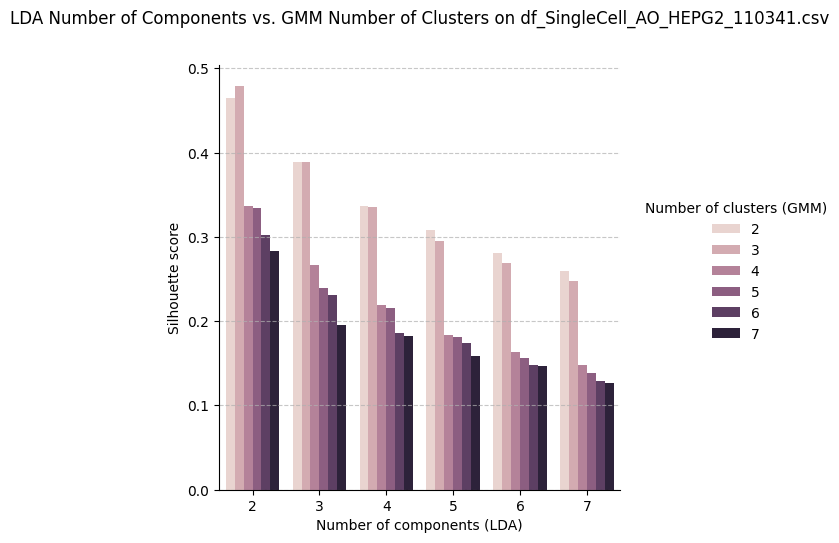

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the catplot
g = sns.catplot(
    data=df_lda,
    kind="bar",
    x="Number of components (LDA)",
    y=f"{eval_method} score",
    hue="Number of clusters (GMM)",
)

# g.ax.set_ylim(40, 45)  # Set y-axis limit to 26,000 as requested
g.ax.grid(True, axis='y', linestyle="--", alpha=0.7)  # Add a grid for better readability

# Add title with margin below
plt.title(f"LDA Number of Components vs. GMM Number of Clusters on {csv_data}", pad=30)

# Adjust layout to prevent label cutoff
# plt.tight_layout()

# Save the figure
plt.savefig(f"{save_dir}/{csv_data}_lda_dimension_{eval_method}_scores.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

### 1. GMM Clusters vs. GMM Covariance

#### BIC scores

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

def gmm_bic_score(estimator, X):
    return -estimator.bic(X)

param_grid = {
    "n_components": range(2, 3), # (2,8)
    "covariance_type": ["spherical", "tied", "diag", "full"],
}

metadata_column = 'Metadata_concentration_perliter'
n_comp = 3  # Number of components for LDA

for name, data in preprocessed_data.items():
    if metadata_column in data['df'].columns:
        X_scaled = data['X_scaled']
        labels = data['df'][metadata_column].astype(str)
        reducer = LDA(n_components=n_comp)
        X_reduced = reducer.fit_transform(X_scaled, labels)
    else:
        print(f"Warning: {metadata_column} not found in {name}.")

results = []

# Iterate over parameter combinations with a progress bar
for params in tqdm(ParameterGrid(param_grid), desc="Grid Search Progress"):
    gmm = GaussianMixture(**params)
    gmm.fit(X_reduced)
    score = gmm_bic_score(gmm, X_reduced)  # Compute BIC on the full dataset
    print(f"Parameters: {params}, Score (negative BIC): {score}")
    results.append((params, score))

# Find the best parameters
best_result = max(results, key=lambda x: x[1])
best_params = best_result[0]
best_score = best_result[1]
print("Best parameters:", best_params)
print("Best score (negative BIC):", best_score)

In [ ]:
import pandas as pd

# Create DataFrame from results
df_bic = pd.DataFrame([
    {
        "param_n_components": params["n_components"],
        "param_covariance_type": params["covariance_type"],
        "mean_test_score": -abs(score)
    }
    for params, score in results
])

# Convert negative BIC to positive BIC (since gmm_bic_score returns negative BIC)
df_bic["mean_test_score"] = -df_bic["mean_test_score"]

# Rename columns to match desired output
df_bic = df_bic.rename(
    columns={
        "param_n_components": "Number of clusters",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)

# Sort by BIC score and display top 5
df_bic.sort_values(by="BIC score").head()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the catplot
g = sns.catplot(
    data=df_bic,
    kind="bar",
    x="Number of clusters",
    y="BIC score",
    hue="Type of covariance",
    
)

# g.ax.set_ylim(250000, 285000)  # Set y-axis limit to 26,000 as requested
# g.ax.set_ylim(400000, 450000)
g.ax.grid(True, axis='y', linestyle="--", alpha=0.7)  # Add a grid for better readability

# Add title with margin below
plt.title(f"GMM Number of Clusters by GMM Covariance Types on {csv_data}", pad=30)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the figure
plt.savefig(f"{save_dir}/{csv_data}_bic_scores.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

#### Silhouette scores

In [72]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score
from tqdm import tqdm

param_grid = {
    "n_components": range(2, 8),  # Silhouette score requires at least 2 clusters
    "covariance_type": ["spherical", "tied", "diag", "full"],
}

metadata_column = 'Metadata_concentration_perliter'
n_comp = 3  # Number of components for LDA

for name, data in preprocessed_data.items():
    if metadata_column in data['df'].columns:
        X_scaled = data['X_scaled']
        labels = data['df'][metadata_column].astype(str)
        reducer = LDA(n_components=n_comp)
        X_reduced = reducer.fit_transform(X_scaled, labels)
    else:
        print(f"Warning: {metadata_column} not found in {name}.")

results = []

for params in tqdm(ParameterGrid(param_grid), desc="Grid Search Progress"):
    gmm = GaussianMixture(**params, random_state=42)
    cluster_labels = gmm.fit_predict(X_reduced)
    # Silhouette score is only valid if there is more than 1 cluster
    if len(set(cluster_labels)) > 1 and -1 not in set(cluster_labels):
        score = silhouette_score(X_reduced, cluster_labels)
    else:
        score = float('-inf')
    print(f"Parameters: {params}, Silhouette Score: {score}")
    results.append((params, score))

# Find the best parameters
best_result = max(results, key=lambda x: x[1])
best_params = best_result[0]
best_score = best_result[1]
print("Best parameters:", best_params)
print("Best Silhouette Score:", best_score)

Grid Search Progress:   4%|▍         | 1/24 [00:05<01:59,  5.19s/it]

Parameters: {'covariance_type': 'spherical', 'n_components': 2}, Silhouette Score: 0.3908583957744623


Grid Search Progress:   8%|▊         | 2/24 [00:10<01:55,  5.25s/it]

Parameters: {'covariance_type': 'spherical', 'n_components': 3}, Silhouette Score: 0.3889577605541201


Grid Search Progress:  12%|█▎        | 3/24 [00:16<01:59,  5.69s/it]

Parameters: {'covariance_type': 'spherical', 'n_components': 4}, Silhouette Score: 0.263810604004744


Grid Search Progress:  17%|█▋        | 4/24 [00:22<01:58,  5.90s/it]

Parameters: {'covariance_type': 'spherical', 'n_components': 5}, Silhouette Score: 0.23431492229059414


Grid Search Progress:  21%|██        | 5/24 [00:28<01:46,  5.63s/it]

Parameters: {'covariance_type': 'spherical', 'n_components': 6}, Silhouette Score: 0.2269516627404536


Grid Search Progress:  25%|██▌       | 6/24 [00:32<01:35,  5.33s/it]

Parameters: {'covariance_type': 'spherical', 'n_components': 7}, Silhouette Score: 0.2233742584722084


Grid Search Progress:  29%|██▉       | 7/24 [00:37<01:28,  5.23s/it]

Parameters: {'covariance_type': 'tied', 'n_components': 2}, Silhouette Score: 0.3885895997165841


Grid Search Progress:  33%|███▎      | 8/24 [00:42<01:22,  5.16s/it]

Parameters: {'covariance_type': 'tied', 'n_components': 3}, Silhouette Score: 0.38947274220647193


Grid Search Progress:  38%|███▊      | 9/24 [00:47<01:14,  5.00s/it]

Parameters: {'covariance_type': 'tied', 'n_components': 4}, Silhouette Score: 0.2661114753580753


Grid Search Progress:  42%|████▏     | 10/24 [00:52<01:08,  4.87s/it]

Parameters: {'covariance_type': 'tied', 'n_components': 5}, Silhouette Score: 0.23848791292225216


Grid Search Progress:  46%|████▌     | 11/24 [00:57<01:03,  4.90s/it]

Parameters: {'covariance_type': 'tied', 'n_components': 6}, Silhouette Score: 0.23709650473926316


Grid Search Progress:  50%|█████     | 12/24 [01:02<01:02,  5.21s/it]

Parameters: {'covariance_type': 'tied', 'n_components': 7}, Silhouette Score: 0.19249228604899374


Grid Search Progress:  54%|█████▍    | 13/24 [01:08<00:58,  5.30s/it]

Parameters: {'covariance_type': 'diag', 'n_components': 2}, Silhouette Score: 0.3518376161724683


Grid Search Progress:  58%|█████▊    | 14/24 [01:13<00:51,  5.20s/it]

Parameters: {'covariance_type': 'diag', 'n_components': 3}, Silhouette Score: 0.3728179301988772


Grid Search Progress:  62%|██████▎   | 15/24 [01:18<00:45,  5.01s/it]

Parameters: {'covariance_type': 'diag', 'n_components': 4}, Silhouette Score: 0.266404671274256


Grid Search Progress:  67%|██████▋   | 16/24 [01:22<00:39,  4.92s/it]

Parameters: {'covariance_type': 'diag', 'n_components': 5}, Silhouette Score: 0.23430616380199293


Grid Search Progress:  71%|███████   | 17/24 [01:27<00:35,  5.01s/it]

Parameters: {'covariance_type': 'diag', 'n_components': 6}, Silhouette Score: 0.2193301207305353


Grid Search Progress:  75%|███████▌  | 18/24 [01:33<00:30,  5.05s/it]

Parameters: {'covariance_type': 'diag', 'n_components': 7}, Silhouette Score: 0.21633003322222186


Grid Search Progress:  79%|███████▉  | 19/24 [01:38<00:25,  5.11s/it]

Parameters: {'covariance_type': 'full', 'n_components': 2}, Silhouette Score: 0.22382449006641453


Grid Search Progress:  83%|████████▎ | 20/24 [01:43<00:20,  5.12s/it]

Parameters: {'covariance_type': 'full', 'n_components': 3}, Silhouette Score: 0.3748061706645355


Grid Search Progress:  88%|████████▊ | 21/24 [01:48<00:15,  5.07s/it]

Parameters: {'covariance_type': 'full', 'n_components': 4}, Silhouette Score: 0.2554324385932808


Grid Search Progress:  92%|█████████▏| 22/24 [01:54<00:10,  5.27s/it]

Parameters: {'covariance_type': 'full', 'n_components': 5}, Silhouette Score: 0.23301777961661693


Grid Search Progress:  96%|█████████▌| 23/24 [01:59<00:05,  5.20s/it]

Parameters: {'covariance_type': 'full', 'n_components': 6}, Silhouette Score: 0.21983832937456516


Grid Search Progress: 100%|██████████| 24/24 [02:04<00:00,  5.20s/it]

Parameters: {'covariance_type': 'full', 'n_components': 7}, Silhouette Score: 0.21511405819934648
Best parameters: {'covariance_type': 'spherical', 'n_components': 2}
Best Silhouette Score: 0.3908583957744623


In [73]:
import pandas as pd

# Create DataFrame from results
df_silhouette = pd.DataFrame([
    {
        "param_n_components": params["n_components"],
        "param_covariance_type": params["covariance_type"],
        "mean_test_score": score
    }
    for params, score in results
])

# Rename columns to match desired output
df_silhouette = df_silhouette.rename(
    columns={
        "param_n_components": "Number of clusters",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "Silhouette score",
    }
)

# Sort by BIC score and display top 5
df_silhouette.sort_values(by="Silhouette score").head()

,Number of clusters,Type of covariance,Silhouette score
11,7,tied,0.192492
23,7,full,0.215114
17,7,diag,0.216330
16,6,diag,0.219330
22,6,full,0.219838


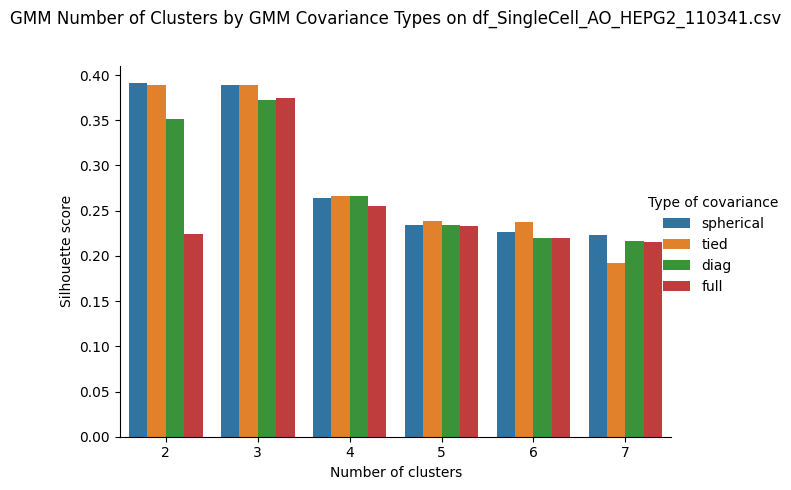

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the catplot
g = sns.catplot(
    data=df_silhouette,
    kind="bar",
    x="Number of clusters",
    y="Silhouette score",
    hue="Type of covariance",
)

# g.ax.set_ylim(250000, 285000)  # Set y-axis limit to 26,000 as requested
# g.ax.grid(True, axis='y', linestyle="--", alpha=0.7)  # Add a grid for better readability

# Add title with margin below
plt.title(f"GMM Number of Clusters vs. GMM Covariance Types on {csv_data}", pad=30)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the figure
plt.savefig(f"{save_dir}/{csv_data}_silhouette_scores.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

#### 2. LDA Dimension vs. GMM Covariance

In [99]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import numpy as np

# Define parameter grid for GMM (only covariance_type)
gmm_param_grid = {
    "covariance_type": ["spherical", "tied", "diag", "full"],
}

# Metadata column for LDA supervision
metadata_column = 'Metadata_concentration_perliter'
gmm_n_components = 3  # Fixed number of components for GMM

# Store results
results = []

# Process each dataset in preprocessed_data
for name, data in preprocessed_data.items():
    if metadata_column in data['df'].columns:
        X_scaled = data['X_scaled']
        labels = data['df'][metadata_column].astype(str)
        
        # Determine max n_components for LDA (min of n_classes-1, n_features)
        n_classes = len(np.unique(labels))
        n_features = X_scaled.shape[1]
        max_n_components = min(n_classes - 1, n_features)
        print("Max n_components for LDA:", max_n_components)
        
        if max_n_components < 1:
            print(f"Warning: Insufficient classes or features for LDA in {csv_data}.")
            continue
            
        # Define parameter grid for LDA
        lda_param_grid = {
            "n_components": range(1, max_n_components + 1)
        }
        
        # Grid search over LDA parameters
        for lda_params in ParameterGrid(lda_param_grid):
            # Apply LDA
            reducer = LinearDiscriminantAnalysis(**lda_params)
            try:
                X_reduced = reducer.fit_transform(X_scaled, labels)
                
                # Grid search over GMM covariance_type
                for gmm_params in tqdm(ParameterGrid(gmm_param_grid), desc=f"LDA n_components={lda_params['n_components']}: GMM Grid Search"):
                    gmm = GaussianMixture(n_components=gmm_n_components, **gmm_params, random_state=42)
                    cluster_labels = gmm.fit_predict(X_reduced)
                    
                    # Compute silhouette score (valid if >1 cluster, no noise labels)
                    if len(set(cluster_labels)) > 1 and -1 not in set(cluster_labels):
                        score = silhouette_score(X_reduced, cluster_labels)
                    else:
                        score = float('-inf')
                        
                    print(f"Dataset: {csv_data}, LDA Parameters: {lda_params}, GMM Parameters: {gmm_params}, Silhouette Score: {score}")
                    results.append({
                        "dataset": csv_data,
                        "lda_params": lda_params,
                        "gmm_params": gmm_params,
                        "score": score
                    })
                    
            except Exception as e:
                print(f"Error for dataset {csv_data}, LDA params={lda_params}: {e}")
                continue
                
    else:
        print(f"Warning: {metadata_column} not found in {csv_data}.")

# Find best result
if results:
    best_result = max(results, key=lambda x: x["score"])
    print(f"Best Dataset: {best_result['dataset']}")
    print(f"Best LDA Parameters: {best_result['lda_params']}")
    print(f"Best GMM Parameters: {best_result['gmm_params']}")
    print(f"Best Silhouette Score: {best_result['score']}")
else:
    print("No valid results found.")

LDA n_components=1: GMM Grid Search:  25%|██▌       | 1/4 [00:14<00:42, 14.29s/it]

Dataset: df_SingleCell_AO_HEPG2_102912.csv, LDA Parameters: {'n_components': 1}, GMM Parameters: {'covariance_type': 'spherical'}, Silhouette Score: 0.5292938153032356


LDA n_components=1: GMM Grid Search:  50%|█████     | 2/4 [00:30<00:31, 15.69s/it]

Dataset: df_SingleCell_AO_HEPG2_102912.csv, LDA Parameters: {'n_components': 1}, GMM Parameters: {'covariance_type': 'tied'}, Silhouette Score: 0.4878458895548503


LDA n_components=1: GMM Grid Search:  75%|███████▌  | 3/4 [00:45<00:15, 15.08s/it]

Dataset: df_SingleCell_AO_HEPG2_102912.csv, LDA Parameters: {'n_components': 1}, GMM Parameters: {'covariance_type': 'diag'}, Silhouette Score: 0.5292938153032356


LDA n_components=1: GMM Grid Search: 100%|██████████| 4/4 [01:00<00:00, 15.16s/it]

Dataset: df_SingleCell_AO_HEPG2_102912.csv, LDA Parameters: {'n_components': 1}, GMM Parameters: {'covariance_type': 'full'}, Silhouette Score: 0.5292938153032356



LDA n_components=2: GMM Grid Search:   0%|          | 0/4 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import pandas as pd

# Create DataFrame from results
df_silhouette = pd.DataFrame([
    {
        "dataset": result["dataset"],
        "param_lda_n_components": result["lda_params"]["n_components"],
        "param_gmm_covariance_type": result["gmm_params"]["covariance_type"],
        "mean_test_score": result["score"]
    }
    for result in results
])

# Rename columns to match desired output
df_silhouette = df_silhouette.rename(
    columns={
        "param_lda_n_components": "Number of Components (LDA)",
        "param_gmm_covariance_type": "Type of Covariance (GMM)",
        "mean_test_score": "Silhouette score",
    }
)

# Sort by silhouette score (descending) and display top 5
df_silhouette.sort_values(by="Silhouette score", ascending=False).head()

,dataset,Number of Components (LDA),Type of Covariance (GMM),Silhouette score
0,df_SingleCell_AO_HEPG2_102912.csv,1,spherical,0.529294
2,df_SingleCell_AO_HEPG2_102912.csv,1,diag,0.529294
3,df_SingleCell_AO_HEPG2_102912.csv,1,full,0.529294
1,df_SingleCell_AO_HEPG2_102912.csv,1,tied,0.487846
5,df_SingleCell_AO_HEPG2_102912.csv,2,tied,0.326227


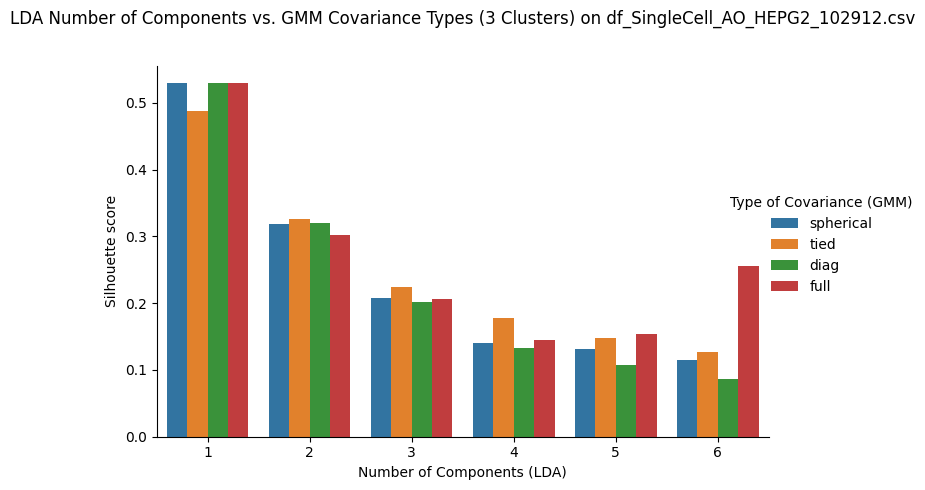

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the catplot
g = sns.catplot(
    data=df_silhouette,
    kind="bar",
    x="Number of Components (LDA)",
    y="Silhouette score",
    hue="Type of Covariance (GMM)",
)

# g.ax.set_ylim(250000, 285000)  # Set y-axis limit to 26,000 as requested
# g.ax.grid(True, axis='y', linestyle="--", alpha=0.7)  # Add a grid for better readability

# Add title with margin below
plt.title(f"LDA Number of Components vs. GMM Covariance Types ({gmm_n_components} Clusters) on {csv_data}", pad=30)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the figure
plt.savefig(f"{save_dir}/{csv_data}_LDA_DimvsGMM_covariance_silhouette_scores.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

### 3. No LDA

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

def gmm_bic_score(estimator, X):
    return -estimator.bic(X)

param_grid = {
    "n_components": range(2, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}

metadata_column = 'Metadata_concentration_perliter'
# n_comp = 3  # Number of components for LDA

for name, data in preprocessed_data.items():
    if metadata_column in data['df'].columns:
        X_scaled = data['X_scaled']
        # labels = data['df'][metadata_column].astype(str)
        # reducer = LDA(n_components=n_comp)
        # X_reduced = reducer.fit_transform(X_scaled, labels)
    else:
        print(f"Warning: {metadata_column} not found in {name}.")

results = []

# Iterate over parameter combinations with a progress bar
for params in tqdm(ParameterGrid(param_grid), desc="Grid Search Progress"):
    gmm = GaussianMixture(**params)
    gmm.fit(X_scaled)
    score = gmm_bic_score(gmm, X_scaled)  # Compute BIC on the full dataset
    print(f"Parameters: {params}, Score (negative BIC): {score}")
    results.append((params, score))

# Find the best parameters
best_result = max(results, key=lambda x: x[1])
best_params = best_result[0]
best_score = best_result[1]
print("Best parameters:", best_params)
print("Best score (negative BIC):", best_score)

#### (Optional) Grid Search: Clustering

In [ ]:
# Apply clustering to reduced data from PCA, LDA, t-SNE, and UMAP
metadata_column = 'Metadata_concentration_perliter'
clustering_methods = ['KMeans', 'DBSCAN', 'Agglomerative', 'GaussianMixture']
reduction_methods = ['LDA']
# reduction_methods = ['PCA', 'LDA', 't-SNE', 'UMAP']
n_components_list = [2, 3]
n_clusters_list = [3, 4, 5, 6, 7, 8]
save_dir = "/home/jen-hungwang/Desktop/eval/"

for name, data in preprocessed_data.items():
    if metadata_column in data['df'].columns:
        X_scaled = data['X_scaled']

        for reduction_method in reduction_methods:
            for n_components in n_components_list:
                # Compute reduced data based on the method
                if reduction_method == 'PCA':
                    reducer = PCA(n_components=n_components)
                    X_reduced = reducer.fit_transform(X_scaled)
                elif reduction_method == 'LDA':
                    labels = data['df'][metadata_column].astype(str)
                    reducer = LDA(n_components=n_components)
                    X_reduced = reducer.fit_transform(X_scaled, labels)
                elif reduction_method == 't-SNE':
                    reducer = TSNE(n_components=n_components, perplexity=30, learning_rate=200, random_state=42)
                    X_reduced = reducer.fit_transform(X_scaled)
                elif reduction_method == 'UMAP':
                    reducer = umap.UMAP(n_components=n_components, n_neighbors=15, min_dist=0.1, random_state=42)
                    X_reduced = reducer.fit_transform(X_scaled)

                for cluster_method in clustering_methods:
                    if cluster_method in ['KMeans', 'Agglomerative', 'GaussianMixture']:
                        for n_clusters in n_clusters_list:
                            labels = perform_clustering(
                                X_reduced, 
                                None, 
                                metadata_column, 
                                cluster_method, 
                                reduction_method, 
                                n_clusters=n_clusters, 
                                save_path=save_dir + f"{name}_{reduction_method}_{cluster_method}_{n_components}D_{n_clusters}clusters"
                            )
                            print(f"{cluster_method} clustering labels on {reduction_method} for {name} ({n_components}D, {n_clusters} clusters): {np.unique(labels)}")
                    elif cluster_method == 'DBSCAN':
                        labels = perform_clustering(
                            X_reduced, 
                            None, 
                            metadata_column, 
                            cluster_method, 
                            reduction_method, 
                            eps=0.5, 
                            min_samples=5, 
                            save_path=save_dir + f"{name}_{reduction_method}_{cluster_method}_{n_components}D"
                        )
                        print(f"{cluster_method} clustering labels on {reduction_method} for {name} ({n_components}D): {np.unique(labels)}")
    else:
        print(f"Warning: {metadata_column} not found in {name}.")

#### (Optional) Subplots

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


figs       = [fig_original, fig_reduced]
fig_labels = ['Original classes',
              'Cluster with dimensionality reduction']
num_plots = 2

# -- 1. build a 3-column subplot skeleton, each cell is 3-D --------------
combined_fig = make_subplots(
    rows=1, cols=num_plots,
    specs=[[{"type": "scene"}]*num_plots],               # 3× Scatter3d panels
    subplot_titles=fig_labels,
    horizontal_spacing=0.07                      # little gap between plots
)

# -- 2. copy every trace into the right cell, tweak the marker size -------
for col, (fig, label) in enumerate(zip(figs, fig_labels), start=1):
    for trace in fig.data:
        # make dots smaller (overwrite whatever size was there)
        if hasattr(trace, "marker"):          # safety check
            trace.marker.size = 3
        # prefix trace names with panel label so the legend is explicit
        trace.name = f"{trace.name}"
        combined_fig.add_trace(trace, row=1, col=col)

# -- 3. carry over each panel’s axis titles -------------------------------
for col, fig in enumerate(figs, start=1):
    if hasattr(fig.layout, "scene"):  # 3-D source figure
        tgt_scene = "scene" if col == 1 else f"scene{col}"
        combined_fig.update_layout({
            tgt_scene: dict(
                xaxis_title = fig.layout.scene.xaxis.title.text,
                yaxis_title = fig.layout.scene.yaxis.title.text,
                zaxis_title = fig.layout.scene.zaxis.title.text
            )
        })
    else:                             # 2-D source figure (just in case)
        combined_fig.update_xaxes(title_text=fig.layout.xaxis.title.text,
                                  row=1, col=col)
        combined_fig.update_yaxes(title_text=fig.layout.yaxis.title.text,
                                  row=1, col=col)

# -- 4. overall figure cosmetics ------------------------------------------
combined_fig.update_layout(
    title="Combined clustering results",
    height=500, width=1350,
    legend=dict(itemsizing="constant")   # keep legend entry size compact
)

combined_fig.show(renderer="browser")

# 4. Evaluation

In [ ]:
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score

In [ ]:
# Evaluation function for clustering results
def evaluate_clustering(X_reduced, labels, df, metadata_column):
    # Convert concentration to categorical labels as ground truth
    true_labels = df[metadata_column].astype(str)
    
    # Silhouette Score
    silhouette_avg = silhouette_score(X_reduced, labels) if len(np.unique(labels)) > 1 else None
    
    # Adjusted Rand Score (requires true labels)
    adjusted_rand = adjusted_rand_score(true_labels, labels) if len(np.unique(labels)) > 1 else None
    
    # Calinski-Harabasz Score
    ch_score = calinski_harabasz_score(X_reduced, labels) if len(np.unique(labels)) > 1 else None
    
    print(f"Evaluation Metrics for Clustering:")
    print(f"Silhouette Score: {silhouette_avg:.4f}" if silhouette_avg is not None else "Silhouette Score: N/A (single cluster)")
    print(f"Adjusted Rand Score: {adjusted_rand:.4f}" if adjusted_rand is not None else "Adjusted Rand Score: N/A (single cluster or no true labels)")
    print(f"Calinski-Harabasz Score: {ch_score:.4f}" if ch_score is not None else "Calinski-Harabasz Score: N/A (single cluster)")
    return silhouette_avg, adjusted_rand, ch_score

In [ ]:
# Evaluate clustering results for each reduction method, clustering method, and dataset
metadata_column = 'Metadata_concentration_perliter'
clustering_methods = ['KMeans', 'DBSCAN', 'Agglomerative']
reduction_methods = ['LDA']
# reduction_methods = ['PCA', 'LDA', 't-SNE', 'UMAP']
n_components = 3
save_dir = "/home/jen-hungwang/Desktop/eval/"

for name, data in preprocessed_data.items():
    if metadata_column in data['df'].columns:
        X_scaled = data['X_scaled']
        
        for reduction_method in reduction_methods:
            # Compute reduced data based on the method
            if reduction_method == 'PCA':
                reducer = PCA(n_components=n_components)
                X_reduced = reducer.fit_transform(X_scaled)
            elif reduction_method == 'LDA':
                labels = data['df'][metadata_column].astype(str)
                reducer = LDA(n_components=n_components)
                X_reduced = reducer.fit_transform(X_scaled, labels)
            elif reduction_method == 't-SNE':
                reducer = TSNE(n_components=n_components, perplexity=30, learning_rate=200, random_state=42)
                X_reduced = reducer.fit_transform(X_scaled)
            elif reduction_method == 'UMAP':
                reducer = umap.UMAP(n_components=n_components, n_neighbors=15, min_dist=0.1, random_state=42)
                X_reduced = reducer.fit_transform(X_scaled)
            
            for cluster_method in clustering_methods:
                if cluster_method == 'KMeans' or cluster_method == 'Agglomerative':
                    labels = perform_clustering(X_reduced, None, metadata_column, cluster_method, reduction_method, n_clusters=3, save_path=save_dir + f"{name}_{reduction_method}_{cluster_method}")
                elif cluster_method == 'DBSCAN':
                    labels = perform_clustering(X_reduced, None, metadata_column, cluster_method, reduction_method, eps=0.5, min_samples=5, save_path=save_dir + f"{name}_{reduction_method}_{cluster_method}")
                print(f"\nEvaluating {cluster_method} clustering on {reduction_method} for {name}:")
                evaluate_clustering(X_reduced, labels, data['df'], metadata_column)
    else:
        print(f"Warning: {metadata_column} not found in {name}.")